In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from features import FeatureEmbeddings
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.metrics import confusion_matrix

from tqdm.notebook import tqdm

import sklearn
import numpy as np


# Data

In [2]:
df = pd.read_csv("data/snopes_phase2_clean_2018_7_3.csv")

In [3]:
target = []
for c in df['fact_rating_phase1']:
    if c == 'legend':
        target.append(1)
    elif c == 'mostly false':
        target.append(1)
    elif c == 'miscaptioned':
        target.append(1)
    elif c == 'outdated':
        target.append(1)
    elif c == 'false':
        target.append(1)
    elif c == 'mixture':
        target.append(1)
    elif c == 'mostly true':
        target.append(0)
    elif c == 'scam':
        target.append(1)
    elif c == 'correct attribution':
        target.append(0)
    elif c == 'misattributed':
        target.append(1)
    elif c == 'true':
        target.append(0)
    elif c == 'unproven':
        target.append(1)

In [4]:
df['target'] = target

In [5]:
df.head()

,fact_rating_phase1,snopes_url_phase1,article_title_phase1,article_category_phase1,article_date_phase1,article_claim_phase1,article_origin_url_phase1,index_paragraph_phase1,page_is_first_citation_phase1,error_phase2,original_article_text_phase2,article_title_phase2,publish_date_phase2,author_phase2,target
0,true,https://www.snopes.com/fact-check/is-trump-adm...,Is the Trump Administration Paying Southwest K...,Politics Politics,22 June 2018,The Trump administration is paying Southwest K...,https://www.dallasnews.com/news/immigration/20...,1,True,No Error,"A Southwest Key spokeswoman, Cindy Casares, ha...",Texas nonprofit has received $1.5 billion in f...,2018-06-19,Jennifer Emily,0
1,true,https://www.snopes.com/fact-check/is-trump-adm...,Is the Trump Administration Paying Southwest K...,Politics Politics,22 June 2018,The Trump administration is paying Southwest K...,https://www.bloomberg.com/news/articles/2018-0...,1,False,No Error,The Trump administration plans to pay a Texas ...,Trumps Immigrant Child Detentions Mean $458 Mi...,2018-06-19,Alex Wayne,0
2,true,https://www.snopes.com/fact-check/is-trump-adm...,Is the Trump Administration Paying Southwest K...,Politics Politics,22 June 2018,The Trump administration is paying Southwest K...,https://web.archive.org/web/20180604042055/htt...,10,False,No Error,Who We Are Southwest Key Programs is a private...,Who We Are: Southwest Key Programs,NaN,NaN,0
3,true,https://www.snopes.com/fact-check/is-trump-adm...,Is the Trump Administration Paying Southwest K...,Politics Politics,22 June 2018,The Trump administration is paying Southwest K...,https://www.hhs.gov/about/budget/fy2018/budget...,10,False,No Error,Administration for Children and Families : Dis...,FY 2018 Budget in Brief - ACF - Discretionary,2017-05-19,NaN,0
4,true,https://www.snopes.com/fact-check/is-trump-adm...,Is the Trump Administration Paying Southwest K...,Politics Politics,22 June 2018,The Trump administration is paying Southwest K...,https://www.justice.gov/opa/pr/attorney-genera...,11,False,No Error,Attorney General Jeff Sessions today notified ...,Attorney General Announces Zero-Tolerance Poli...,NaN,NaN,0


In [6]:
len(df[df.target==0])

2187

In [7]:
sub1 = df[df.target==1].sample(8000, random_state = 33)
sub2 = df[df.target==0].sample(2000, random_state = 33)
subset = sub1.append(sub2)
subset = subset.sample(frac = 1) # this is where your randomize. So that the specific articles can still be tracked.
subset[subset['target']==1].head()

,fact_rating_phase1,snopes_url_phase1,article_title_phase1,article_category_phase1,article_date_phase1,article_claim_phase1,article_origin_url_phase1,index_paragraph_phase1,page_is_first_citation_phase1,error_phase2,original_article_text_phase2,article_title_phase2,publish_date_phase2,author_phase2,target
4272,mixture,https://www.snopes.com/fact-check/schnapp-judg...,Fireball Whisky Recall,Food,28 October 2014,Fireball whisky is being recalled due to conce...,http://www.accessdata.fda.gov/scripts/cdrh/cfd...,10,True,No Error,"Propylene glycol (C3H8O2, CAS Reg. No. 57-55-...",CFR - Code of Federal Regulations Title 21,NaN,NaN,1
10588,false,https://www.snopes.com/fact-check/onion-in-you...,Does Putting a Raw Cut Onion in Your Sock Cure...,Medical Science,24 January 2017,"Placing a raw, cut onion in contact with your ...",http://link.springer.com/chapter/10.1007/978-1...,10,False,No Error,Abstract Acupuncture is an ancient medical tec...,History of Acupuncture,2014-07-20,Jen-Hwey Chiu,1
12178,false,https://www.snopes.com/fact-check/captain-khan...,Captain Khans Epitaph: Beware of Dying as an A...,Military Politics,2 August 2016,The headstone of the late U.S. Army Capt. Huma...,http://www.snopes.com/khizr-khan-is-a-muslim-b...,1,True,No Error,"CLAIM DNC speaker Khizr Khan, father of fallen...",Khizr Khan Is a Muslim Brotherhood Agent,NaN,Kim Lacapria,1
15236,unproven,https://www.snopes.com/fact-check/craigslist-a...,Craigslist Ads Recruit Paid Protesters for Tru...,Uncategorized,14 March 2016,Ads on Craigslist sought to recruit paid prote...,https://en.wikipedia.org/wiki/Grassroots_Campa...,8,False,No Error,"Grassroots Campaigns, Inc. is a for-profit cor...","Grassroots Campaigns, Inc.",NaN,NaN,1
2550,mixture,https://www.snopes.com/fact-check/trump-dogs-v...,President Trump Abruptly Shuts Down Dogs for W...,Politics Military,13 November 2017,President Trump abruptly closed the Dogs for W...,https://wtop.com/local/2017/11/16542896/slide/1/,38,False,No Error,Soon after an organization that provides dogs ...,Veterinarian gave therapy dog group booted fro...,2017-11-16,News Traffic Weather,1


In [8]:
type(subset)
subset['article_title_phase2']

4272            CFR - Code of Federal Regulations Title 21
10588                               History of Acupuncture
12178             Khizr Khan Is a Muslim Brotherhood Agent
15236                           Grassroots Campaigns, Inc.
1798     Senate Tax Plan Includes Exemption for Private...
                               ...                        
2464          Joe Arpaio: Tent City a "Concentration Camp"
7718     Who Is Britain First's Jayda Fransen, the U.K....
1288     Biosphoto : Agence Photographique spcialise da...
8130     The last frontier: Cinderella cosmetic foot su...
2690     FACT CHECK: Are Hotels Required to Accept Pets...
Name: article_title_phase2, Length: 10000, dtype: object

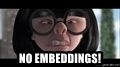

In [9]:
embeddings = FeatureEmbeddings()
embeddings.create(subset,article_col='original_article_text_phase2',url_col='article_origin_url_phase1',header_col='article_title_phase2')

Building embeddings for headlines...
Building bigram model features for URL strings...
Calculating edit distance for each URL string...
Inferring article embeddings via doc2vec...


In [10]:
embeddings.features['target'] = subset['target'].reset_index(drop=True)
just_url = embeddings.features.loc[:, [x for x in embeddings.features.columns if '_vec_' not in x]]
splt = int(len(just_url)*7.5/10.0)
train_df = just_url.iloc[:splt, :]
test_df = just_url.iloc[splt:, :]


In [11]:
test_df.iloc[0], just_url.iloc[splt]

(bigram_entropy              4.725191
 bigram_perplexity          26.449911
 clean_bigram_entropy        4.491028
 clean_bigram_perplexity    22.487133
 edit_distance               7.000000
 target                      1.000000
 Name: 7500, dtype: float64,
 bigram_entropy              4.725191
 bigram_perplexity          26.449911
 clean_bigram_entropy        4.491028
 clean_bigram_perplexity    22.487133
 edit_distance               7.000000
 target                      1.000000
 Name: 7500, dtype: float64)

In [12]:
embeddings.features.head()

,a_vec_0,a_vec_1,a_vec_2,a_vec_3,a_vec_4,a_vec_5,a_vec_6,a_vec_7,a_vec_8,a_vec_9,...,h_vec_96,h_vec_97,h_vec_98,h_vec_99,bigram_entropy,bigram_perplexity,clean_bigram_entropy,clean_bigram_perplexity,edit_distance,target
0,1.690243,3.322694,4.778473,0.779409,-1.120178,2.524984,-2.908352,-6.873127,-1.147007,-1.275854,...,0.329498,0.160623,0.078988,-0.062167,5.189236,36.485121,4.766799,27.223851,12,1
1,-1.635669,2.348241,4.364545,4.069299,-1.112790,2.975624,0.334799,-2.363841,1.673298,-1.864265,...,0.574479,0.138165,0.107556,-0.157290,5.427688,43.042455,4.823306,28.311296,10,1
2,-1.064135,-1.136840,1.892159,-1.888878,-4.578509,4.879102,-3.924465,-4.199763,-2.317177,-2.606999,...,0.174077,0.062964,0.053858,-0.035662,4.747413,26.860482,4.420173,21.409408,5,1
3,-1.639039,5.328935,7.290020,4.064803,-0.256419,6.074230,-2.066190,-6.026893,-3.806900,2.717588,...,0.255730,0.161661,0.163758,-0.014004,5.294637,39.250431,4.782023,27.512642,13,1
4,-0.530776,0.629445,1.603321,0.771640,1.591816,2.663206,-0.455793,-1.642991,-2.416720,2.006050,...,0.480640,0.441574,0.377050,0.069472,5.502714,45.340054,4.568667,23.730437,0,0


In [13]:
train_df.head()

,bigram_entropy,bigram_perplexity,clean_bigram_entropy,clean_bigram_perplexity,edit_distance,target
0,5.189236,36.485121,4.766799,27.223851,12,1
1,5.427688,43.042455,4.823306,28.311296,10,1
2,4.747413,26.860482,4.420173,21.409408,5,1
3,5.294637,39.250431,4.782023,27.512642,13,1
4,5.502714,45.340054,4.568667,23.730437,0,0


In [14]:
train_df.to_csv('embeddings/full_train_df.csv',index=False)
test_df.to_csv('embeddings/full_test_df.csv',index=False)

In [15]:
class Network(nn.Module):
    def __init__(self, in_dim, out_dim=2):
        super().__init__()
        
        self.hidden1 = nn.Linear(in_dim, 32)
        self.hidden2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, out_dim)
        
        self.activation = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden1(x)
        x = self.activation(x)
        x = self.hidden2(x)
        x = self.activation(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

In [16]:
class FakeNewsDataset(Dataset):
    def __init__(self, df):
        self.data = df.drop(columns=['target'])
        self.targets = df['target'].astype(int)
    
    def __getitem__(self, i):
        x = torch.tensor(self.data.iloc[i]).float()
        y = torch.tensor(self.targets.iloc[i]).long()
        return x, y
    
    def __len__(self):
        return len(self.data)

In [17]:
train_dataset = FakeNewsDataset(train_df)
val_dataset = FakeNewsDataset(test_df)

num_epochs = 150
batch_size = 30

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

model = Network(len(test_df.columns)-1, 2)
# Use the code below to load
path = "models/no-embeddings-fake-news-classifier.pt" 
# model.load_state_dict(torch.load(path))

objective = torch.nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [18]:
train_dataset.data.ndim

2

In [19]:
# Run your training / validation loops

train_losses_avgs = []
validate_losses_avgs = []

train_loop = tqdm(total=len(train_loader) * num_epochs, position=0) # the little progress bar thing
validate_loop = tqdm(total=len(val_loader) * num_epochs, position=0)

for epoch in range(num_epochs):
    
    train_losses = []
    
    for x, y_truth in train_loader:

        optimizer.zero_grad() # forget about the gradient you computed last time

        y_hat = model(x)
        loss = objective(y_hat, y_truth)

        train_losses.append(loss)
        
        train_loop.set_description('Training loss: {:.4f}'.format(loss.item()))
        train_loop.update(1)
        
        loss.backward() # computes the gradient and stores it in the variable

        optimizer.step()
    
    train_losses_avgs.append(sum(train_losses) / len(train_losses))
    
    validate_losses = []
    
    for x, y_truth in val_loader:

        y_hat = model(x)
        loss = objective(y_hat, y_truth)

        validate_losses.append(loss)
        
        validate_loop.set_description('Validation loss: {:.4f}'.format(loss.item()))
        validate_loop.update(1)
    
    validate_losses_avgs.append(sum(validate_losses) / len(validate_losses))
    
    
train_loop.close()
validate_loop.close()

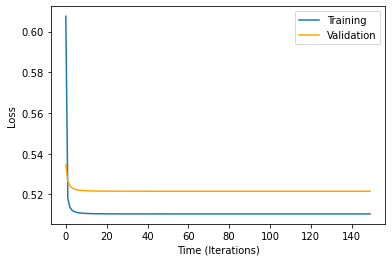

In [20]:
plt.plot(train_losses_avgs, label='Training')
plt.plot(validate_losses_avgs, color='orange', label='Validation')
plt.xlabel('Time (Iterations)')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing

In [21]:
correct = 0
total = 0
y_hat = []
y_true = []
with torch.no_grad():
    for x, targets in val_loader:
        prediction = model(x)
        _, predicted = torch.max(prediction.data, 1)
        for pred, target in zip(predicted, targets):
            y_hat.append(int(pred))
            y_true.append(int(target))
            total += 1
            if pred == target:
                correct += 1

cm = confusion_matrix(y_true, y_hat)
tn, fp, fn, tp = cm.ravel()
# recall = true positives / (true positives + false negatives)
# precision = true positives / (true positives + false positives)
print('Accuracy:', correct / total)
print('Recall:', tp / (tp + fn))
print('Precision:', tp / (tp + fp))

Accuracy: 0.7916
Recall: 1.0
Precision: 0.7916


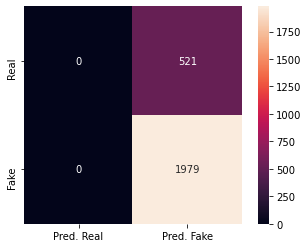

In [22]:
df = pd.DataFrame(cm, index = ['Real', 'Fake'], columns= ['Pred. Real', 'Pred. Fake'])
sns.heatmap(df, square=True, annot=True, vmin=0, fmt="d")
plt.show()

In [23]:
# Save model weights
path = "models/no-embeddings-fake-news-classifier.pt" 
torch.save(model.state_dict(), path) # save model locally
# Use the code below to load
#model.load_state_dict(torch.load(path))

Notes today:

- make sure to normalize the features that aren't in article/header embedding space (so they don't overpower the other ones)
- retrain the doc2vec model with all the data you can find
- model inference (shap, lime)
- try linear regression, understand what's going on

# LIME - Tabular

In [24]:
id_chosen = 1113 # decide on which example article to use with LIME.

Choose from these articles to test:

In [25]:
subset[subset['target']==0].head(3) # true news

,fact_rating_phase1,snopes_url_phase1,article_title_phase1,article_category_phase1,article_date_phase1,article_claim_phase1,article_origin_url_phase1,index_paragraph_phase1,page_is_first_citation_phase1,error_phase2,original_article_text_phase2,article_title_phase2,publish_date_phase2,author_phase2,target
1798,mostly true,https://www.snopes.com/fact-check/gop-tax-plan...,Does the GOP Tax Plan Include a Tax Cut for Pr...,Politics,20 November 2017,The Senate GOP tax reform bill includes a tax ...,https://www.nytimes.com/2017/11/17/business/se...,3,False,No Error,It may look like a giveaway to rich people who...,Senate Tax Plan Includes Exemption for Private...,2017-11-17,NaN,0
1821,mostly true,https://www.snopes.com/fact-check/katie-hopkin...,Did Liberal Feminist Katie Hopkins Advocate Eu...,Uncategorized,5 September 2017,Liberal feminist Katie Hopkins advocated for d...,https://rationalwiki.org/wiki/Katie_Hopkins,10,False,No Error,From RationalWiki Having stated that she wil...,Katie Hopkins,NaN,NaN,0
792,true,https://www.snopes.com/fact-check/diabetes-vac...,Finnish Researchers Set to Start Type 1 Diabet...,Medical,21 July 2017,"In July 2017, it was announced that Finnish re...",http://www.prnewswire.com/news-releases/proven...,12,False,No Error,"LEBANON, N.J., June 26, 2017 /PRNewswire/ -- P...","Provention Bio, Inc. Secures $28.4 Million Fou...",NaN,NaN,0


In [26]:
subset[subset['target']==1].head(20) # fake news

,fact_rating_phase1,snopes_url_phase1,article_title_phase1,article_category_phase1,article_date_phase1,article_claim_phase1,article_origin_url_phase1,index_paragraph_phase1,page_is_first_citation_phase1,error_phase2,original_article_text_phase2,article_title_phase2,publish_date_phase2,author_phase2,target
4272,mixture,https://www.snopes.com/fact-check/schnapp-judg...,Fireball Whisky Recall,Food,28 October 2014,Fireball whisky is being recalled due to conce...,http://www.accessdata.fda.gov/scripts/cdrh/cfd...,10,True,No Error,"Propylene glycol (C3H8O2, CAS Reg. No. 57-55-...",CFR - Code of Federal Regulations Title 21,NaN,NaN,1
10588,false,https://www.snopes.com/fact-check/onion-in-you...,Does Putting a Raw Cut Onion in Your Sock Cure...,Medical Science,24 January 2017,"Placing a raw, cut onion in contact with your ...",http://link.springer.com/chapter/10.1007/978-1...,10,False,No Error,Abstract Acupuncture is an ancient medical tec...,History of Acupuncture,2014-07-20,Jen-Hwey Chiu,1
12178,false,https://www.snopes.com/fact-check/captain-khan...,Captain Khans Epitaph: Beware of Dying as an A...,Military Politics,2 August 2016,The headstone of the late U.S. Army Capt. Huma...,http://www.snopes.com/khizr-khan-is-a-muslim-b...,1,True,No Error,"CLAIM DNC speaker Khizr Khan, father of fallen...",Khizr Khan Is a Muslim Brotherhood Agent,NaN,Kim Lacapria,1
15236,unproven,https://www.snopes.com/fact-check/craigslist-a...,Craigslist Ads Recruit Paid Protesters for Tru...,Uncategorized,14 March 2016,Ads on Craigslist sought to recruit paid prote...,https://en.wikipedia.org/wiki/Grassroots_Campa...,8,False,No Error,"Grassroots Campaigns, Inc. is a for-profit cor...","Grassroots Campaigns, Inc.",NaN,NaN,1
2550,mixture,https://www.snopes.com/fact-check/trump-dogs-v...,President Trump Abruptly Shuts Down Dogs for W...,Politics Military,13 November 2017,President Trump abruptly closed the Dogs for W...,https://wtop.com/local/2017/11/16542896/slide/1/,38,False,No Error,Soon after an organization that provides dogs ...,Veterinarian gave therapy dog group booted fro...,2017-11-16,News Traffic Weather,1
8140,false,https://www.snopes.com/fact-check/was-security...,Was the Security Guard at Mandalay Bay an Acco...,Uncategorized,7 October 2017,Mandalay Bay security guard Jesus Campos was a...,http://www.snopes.com/manchester-attack-false-...,3,False,No Error,CLAIM The suicide bombing attack at the Ariana...,FACT CHECK: Was the Manchester Terror Attack a...,NaN,Bethania Palma,1
3643,mixture,https://www.snopes.com/fact-check/catching-sex...,Catching Sexually Transmitted Diseases While T...,Medical,18 July 2016,Improperly cleaned tanning beds are vectors fo...,http://www.ncbi.nlm.nih.gov/books/NBK26917/,11,False,No Error,Introduction to Pathogens We normally think of...,Introduction to Pathogens,NaN,Bruce Alberts,1
4476,mostly false,https://www.snopes.com/fact-check/woman-say-th...,Did a Woman Say a Theme Park Fat-Shamed Her Be...,Entertainment Viral Phenomena,14 May 2018,"A woman claimed she was ""fat shamed"" by a Harr...",https://archive.fo/8An0a,11,False,No Error,White privilege has been the law from the day ...,White House Releases Picture Of 2018 Interns. ...,2018-05-15,NaN,1
6039,mostly false,https://www.snopes.com/fact-check/rumors-about...,Rumors About Target,Uncategorized,4 November 2002,Various rumors about the Target chain of retai...,http://www.forbes.com/maserati/cx_aw_1023givin...,21,False,No Error,Donations America's Most Generous Corporations...,Forbes.com: America's Most Generous Corporations,NaN,Jimin Kim,1
11443,false,https://www.snopes.com/fact-check/kiss-no-makeup/,Groom Sues New Wife for Fraud After Seeing Her...,Fake News,5 August 2015,A man sued his bride after seeing her without ...,http://gulfnews.com/news/uae/society/bride-dum...,20,False,No Error,Image for illustrative purpose only. Sharjah: ...,Bride dumped for not looking pretty without ma...,2016-10-16,Aghaddir Ali,1


In [27]:
idx = subset.index.get_loc(subset.loc[id_chosen].name) # based on the id_chosen of the news article,
idx # set its index (iloc) as the one to test via LIME

9832

In [28]:
class_names = ['true', 'fake'] # 0 is a real news source, 1 is fake news

In [29]:
# verify that indeed, the pre- and post-embedding sets have the same order. 
myguy = pd.DataFrame([(train_df.iloc[x]['target'], subset.iloc[x]['target']) for x in range(500)]) # 'target' is the same value for both
len(myguy[myguy[0]==myguy[1]]) # if the two columns are the same for all, then it's the same order. 

500

In [30]:
from lime.lime_tabular import LimeTabularExplainer 
# it requires the train or test dataset. I don't actually know why, because text explainer doesn't.
explainer = LimeTabularExplainer(train_df.to_numpy(), class_names=class_names, feature_names=train_df.columns.values)

In [31]:
def predict(ra):
    row = pd.DataFrame(ra, columns=test_df.columns)
    dataset = FakeNewsDataset(row)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    predictions = []
    for x, targets in loader:
        prediction = model(x)
#         print(prediction.data)
#         print('space')
        predicted = prediction.data
#         predicted = nn.slice(prediction.data, [1,0], [1, len(prediction.data)])
#         predicted = torch.sum(prediction.data, 1)
#         print(predicted)
#         predicted = prediction.data
#         print(predicted.item())
        for pred, target in zip(predicted, targets):
#             print(pred)
#             print(pred[1])
#             y_hat.append(int(pred))
#             y_true.append(int(target))
#             total += 1
#             if pred == target:
#                 correct += 1
            predictions.append([pred[0],pred[1]])
    return np.array(predictions)

ra = predict(test_df.to_numpy())
print(len(predict(test_df.to_numpy())))
print(type(ra))
print(ra)
# test_df.to_numpy()
# go = test_df.to_numpy()[3]
# go.reshape(go.size, go.ndim+1)
# pd.DataFrame([test_df.to_numpy()[5]], columns=test_df.columns)



2500
<class 'numpy.ndarray'>
[[4.3932878e-11 1.0000000e+00]
 [3.8541877e-13 1.0000000e+00]
 [4.2686885e-20 1.0000000e+00]
 ...
 [5.7349276e-21 1.0000000e+00]
 [5.8244608e-14 1.0000000e+00]
 [4.0456291e-10 1.0000000e+00]]


In [32]:
deal = train_df.iloc[idx].to_numpy()

IndexError: single positional indexer is out-of-bounds

In [ ]:
exp = explainer.explain_instance(train_df.iloc[idx].to_numpy(), predict_fn=predict, num_features = 250)
print('Document id: %d' % idx)
subset.iloc[idx]['article_title_phase2']

In [ ]:
subset.iloc[idx]

In [ ]:
print('article: ', subset.iloc[idx]['article_title_phase2'])
print('Probability(fake) =', predict([train_df.iloc[idx].to_numpy()])[0])
print('Truth class: %s' % class_names[train_df['target'].iloc[idx]])

In [ ]:
# don't. it's jumbled because I let all 200 in.
# %matplotlib inline
# fig = exp.as_pyplot_figure()

In [ ]:
# custom list of features to consider, summing up all the word vector embeddings into a single feature.
lst = [('embeddings', sum([x[1] for x in exp.as_list() if ('_vec_' in x[0])]))] \
    + [x for x in exp.as_list() if ('_vec_' not in x[0])]

# taken from LIME source code
%matplotlib inline
vals = [x[1] for x in lst]
names = [x[0] for x in lst]
vals.reverse()
names.reverse()
colors = ['green' if x > 0 else 'red' for x in vals]
pos = np.arange(len(lst)) + .5
plt.barh(pos, vals, align='center', color=colors)
plt.yticks(pos, names)
title = 'Local explanation for class' 
plt.title(title)
subset.iloc[idx]['article_origin_url_phase1']

As you can see above, the word vector embeddings has a huge influence, so it's best to individually see what words or structures contribute most to our results.

In [ ]:
exp.show_in_notebook() # it's messy, since each embedding (of 200) is considered.

In [ ]:
# this little line will tell how heavily contradictory the word embeddings part is.
('article_text', sum([x[1] for x in exp.as_list() if ('_vec_' in x[0]) and x[1]>0]))